# Activation

[![Open in Colab](https://img.shields.io/badge/Open%20in%20Colab-F9AB00?style=for-the-badge&logo=googlecolab&color=525252)](https://colab.research.google.com/github/H-IAAC/CST-Python/blob/main/examples/Activation%20and%20Monitoring.ipynb) [![Open in Github](https://img.shields.io/badge/Open%20in%20Github-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/H-IAAC/CST-Python/blob/main/examples/Activation%20and%20Monitoring.ipynb)

Each codelet has two outputs: the "standard output", which corresponds to the memories that the codelet writes, and the "activation". The "activation" level ranges from 0.0 to 1.0, and can tell different things, like the relevance of the codelet output for attention mechanisms.

In this example, we are going to see how to change the codelet activation level, and execute it's `proc` only when the activation is above the codelet threshould. The default threshould is 0.0.

We are also going to see how to retrieve a mind element and monitor the mind state. 

Lets start by importing the necessary modules:

In [16]:
try:
    import cst_python
except:
    !python3 -m pip install cst_python

In [29]:
from __future__ import annotations

import time # Sleep
import math # Math operations

import numpy as np # Arrays operation
import matplotlib.pyplot as plt # Plot data

import cst_python as cst # CST-Python module

## Codelet definition

We are going to implement a architecture with two codelets: a `SensorCodelet` that reads a input value, multiplies by 10 and send to the output. Also, it's activation level is setted to the input value clipped in [0.0, 1.0] in the `calculate_activation`:

In [18]:
class SensorCodelet(cst.Codelet):
    def __init__(self, name:str) -> None:
        super().__init__()

        self.name = name
        self._ascending = True

        self._input_mo : cst.MemoryObject = None
        self._output_mo : cst.MemoryObject = None
        self._n_run = 0

    def access_memory_objects(self) -> None:
        self._input_mo = self.get_input(name="SensoryInput")
        self._output_mo = self.get_output(name="SensoryOutput")

    def calculate_activation(self) -> None:
        read_value : float = self._input_mo.get_info()
        read_value = np.clip(read_value, 0.0, 1.0)

        self.activation = read_value

    def proc(self) -> None:
        read_value : float = self._input_mo.get_info()
        read_value *= 10

        self._output_mo.set_info(read_value)


The other codelet, the `MotorCodelet`, set it's action as `True` if the input ceil is divisible by 2:

In [19]:
class MotorCodelet(cst.Codelet):
    def __init__(self, name:str) -> None:
        super().__init__()

        self.name = name
        self._ascending = True

        self._minput_mo : cst.MemoryObject = None
        self._output_mo : cst.MemoryObject = None

    def access_memory_objects(self) -> None:
        self._minput_mo = self.get_input(name="SensoryOutput")
        self._output_mo = self.get_output(name="Action")

    def calculate_activation(self) -> None:
        pass

    def proc(self) -> None:
        read_value : float = self._minput_mo.get_info()
        
        action = math.ceil(read_value) % 2 == 0 

        self._output_mo.set_info(action)

## Mind creation

We than create the mind with all the codelets and memories:

In [20]:
def prepare_mind() -> cst.Mind:
    mind = cst.Mind()


    m1 = mind.create_memory_object("SensoryInput", 0.0)
    m2 = mind.create_memory_object("SensoryOutput", 0.0)
    m3 = mind.create_memory_object("Action", False)


    c = SensorCodelet("Sensor1")
    c.add_input(m1)
    c.add_output(m2)
    mind.insert_codelet(c,"Sensory")

    c2 = MotorCodelet("Motor1")
    c2.add_input(m2)
    c2.add_output(m3)
    mind.insert_codelet(c2,"Motor")

    c.time_step = 10
    c2.time_step = 10
    
    mind.start()
    
    return mind

In [21]:
mind = prepare_mind()

## Getting mind elements

Sometimes, we also need the retrieve a mind element after it's creation. In this case, we can manually inspect the `Raw Memory` and the `Code Rack`:

In [22]:
for codelet in mind.code_rack.all_codelets:
    if isinstance(codelet, SensorCodelet):
        sensor_codelet = codelet
        break

In [23]:
input_memory = mind.raw_memory.get_all_of_type("SensoryInput")[0]
sensory_output_memory = mind.raw_memory.get_all_of_type("SensoryOutput")[0]
action_memory = mind.raw_memory.get_all_of_type("Action")[0]

## Execution

With all the elements, we can execute the mind for 100 time steps and store desired values from the mind, in this case the `SensoryCodelet` activation, the input, sensory otput and action memories values.

The input value is going to be manually setted as value from 0 to 1. The `SensoryCodelet` threshould will be changed to 0.7 in the middle of the execution.

Because we wanna monitor the mind, we are to step the sample time step as half the codelet time step. 

In [24]:
sleep_time = (10/2)/1000 #Half codelet execution time in seconds

Store the value history:

In [25]:
n_step = 100

activation_hist = np.empty(n_step, dtype=np.float64)
input_hist = np.empty(n_step, dtype=np.float64)
sensory_output_hist = np.empty(n_step, dtype=np.float64)
action_hist = np.empty(n_step, dtype=bool)

for i in range(n_step):
    input_value = i / n_step
    
    input_memory.set_info(input_value)

    input_hist[i] = input_memory.get_info()
    sensory_output_hist[i] = sensory_output_memory.get_info()
    action_hist[i] = action_memory.get_info()
    activation_hist[i] = sensor_codelet.activation
    
    # Change threshould
    if i == 50:
        sensor_codelet.threshold = 0.7

    time.sleep(sleep_time)

In [26]:
mind.shutdown()

## Results

We can see the stored values:

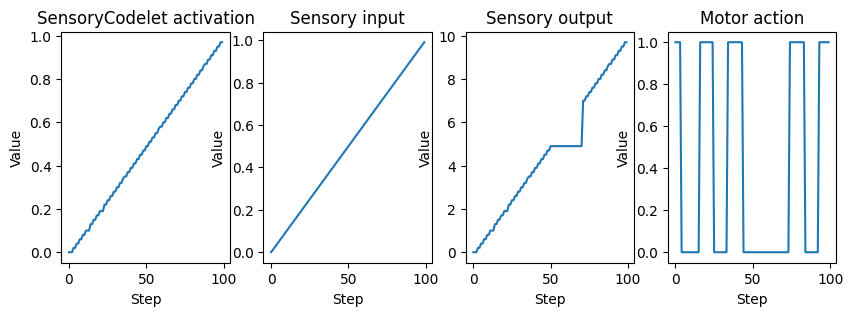

In [27]:
fig, axs  = plt.subplots(1, 4, figsize=(10, 3))

axs : list[plt.Axes]

axs[0].plot(activation_hist)
axs[0].set_title("SensoryCodelet activation")

axs[1].plot(input_hist)
axs[1].set_title("Sensory input")

axs[2].plot(sensory_output_hist)
axs[2].set_title("Sensory output")

axs[3].plot(action_hist)
axs[3].set_title("Motor action")

for ax in axs:
    ax.set_xlabel("Step")
    ax.set_ylabel("Value")

plt.show()

Observe that, because whe changed the threshould to 0.7 in the middle of the execution, the `SensoryCodelet` stops executing to when its activation is above that.

One insteresting detail is that, because the codelet is executed in _time step_ intervals, there is a delay between its input change to the `proc` execution with the output change:

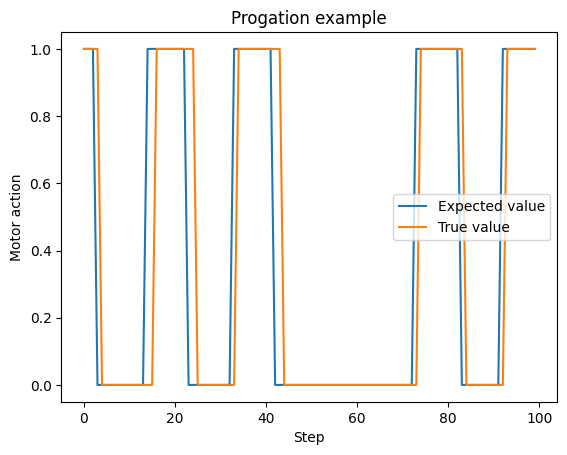

In [28]:
plt.title("Progation example")
plt.xlabel("Step")
plt.ylabel("Motor action")

plt.plot(np.ceil(sensory_output_hist) % 2 == 0, label="Expected value")
plt.plot(action_hist, label="True value")

plt.legend()
plt.show()